<a href="https://colab.research.google.com/github/WeronikaRedlinska/ForexForecast/blob/main/Half_hour_LSTM_ARIMA_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Magisterka2025/LSTM/data

/content/drive/MyDrive/Magisterka2025/LSTM/data


In [3]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# Standard Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
from sklearn.model_selection import ParameterGrid

# Darts functions
from darts.timeseries import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel

#importing data

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

import os

In [20]:
import yfinance as yf
import pandas as pd

# EURUSD ticker symbol on Yahoo Finance
ticker = 'EURUSD=X'

# Define the date range for April 2024
start_date = '2025-04-01'
end_date = '2025-05-01'

# Download the hourly data
data = yf.download(
    tickers=ticker,
    interval='30m',
    start=start_date,
    end=end_date,
    progress=False
)

# Check if data was retrieved
if data.empty:
    print("No data retrieved. yfinance may not provide hourly Forex data for this range.")
else:
    # Save to CSV
    data.to_csv('EURUSD_halfhourly_april2025.csv')
    print("Data saved to EURUSD_halfhourly_april2025.csv")
    print(data.head())


Data saved to EURUSD_halfhourly_april2025.csv
Price                         Close      High       Low      Open   Volume
Ticker                     EURUSD=X  EURUSD=X  EURUSD=X  EURUSD=X EURUSD=X
Datetime                                                                  
2025-03-31 23:00:00+00:00  1.081900  1.082251  1.081783  1.082134        0
2025-03-31 23:30:00+00:00  1.082017  1.082134  1.081783  1.081900        0
2025-04-01 00:00:00+00:00  1.082485  1.082837  1.082134  1.082134        0
2025-04-01 00:30:00+00:00  1.082837  1.082954  1.082368  1.082485        0
2025-04-01 01:00:00+00:00  1.082720  1.082954  1.082485  1.082720        0


In [23]:
df = pd.read_csv("/content/drive/MyDrive/Magisterka2025/LSTM/data/EURUSD_halfhourly_april2025.csv")
df = df.drop([0,1])
df = df.rename(columns={'Price':'Date'})
headers = ['Close','High','Low','Open']
for header in headers:
  df[header]=df[header].astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date", inplace= True)


df['prev_close'] = df['Close'].shift(1)
df['Return']=(df['Close']/df['prev_close'] - 1)*100
df = df.iloc[1:]
df = df.loc[:, [ 'Return', 'Close', 'High', 'Low', 'Open', 'Volume', 'prev_close']]
df.head()

,Return,Close,High,Low,Open,Volume,prev_close
Date,,,,,,,
2025-03-31 23:30:00+00:00,0.010820,1.082017,1.082134,1.081783,1.081900,0,1.081900
2025-04-01 00:00:00+00:00,0.043309,1.082485,1.082837,1.082134,1.082134,0,1.082017
2025-04-01 00:30:00+00:00,0.032476,1.082837,1.082954,1.082368,1.082485,0,1.082485
2025-04-01 01:00:00+00:00,-0.010822,1.082720,1.082954,1.082485,1.082720,0,1.082837
2025-04-01 01:30:00+00:00,-0.032469,1.082368,1.082603,1.082017,1.082603,0,1.082720


In [24]:
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='30min')
df = df.reindex(full_range)
df = df.fillna(method='ffill')
df.head()


<ipython-input-24-e34410ccf8af>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


,Return,Close,High,Low,Open,Volume,prev_close
2025-03-31 23:30:00+00:00,0.010820,1.082017,1.082134,1.081783,1.081900,0,1.081900
2025-04-01 00:00:00+00:00,0.043309,1.082485,1.082837,1.082134,1.082134,0,1.082017
2025-04-01 00:30:00+00:00,0.032476,1.082837,1.082954,1.082368,1.082485,0,1.082485
2025-04-01 01:00:00+00:00,-0.010822,1.082720,1.082954,1.082485,1.082720,0,1.082837
2025-04-01 01:30:00+00:00,-0.032469,1.082368,1.082603,1.082017,1.082603,0,1.082720


In [25]:
series = TimeSeries.from_dataframe(df, value_cols='Return', freq='30min' )
train_size = int(0.8 * len(series))
train, val = series[:train_size], series[train_size:]

In [26]:
series

<TimeSeries (DataArray) (time: 1439, component: 1, sample: 1)> Size: 12kB
array([[[ 0.01082018]],

       [[ 0.0433091 ]],

       [[ 0.03247602]],

       ...,

       [[ 0.        ]],

       [[-0.04531084]],

       [[ 0.01133284]]])
Coordinates:
  * time       (time) datetime64[ns] 12kB 2025-03-31T23:30:00 ... 2025-04-30T...
  * component  (component) <U6 24B 'Return'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

<Axes: xlabel='time'>

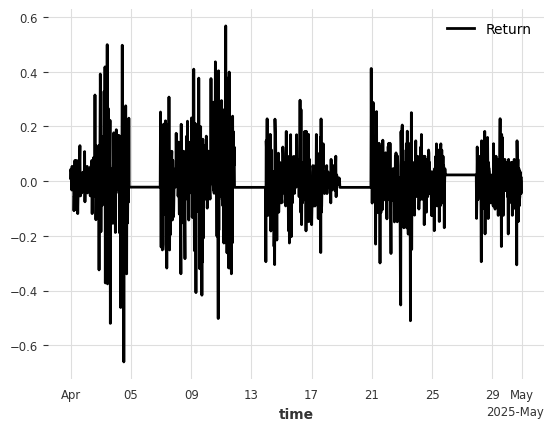

In [27]:
series.plot()

<Axes: xlabel='time'>

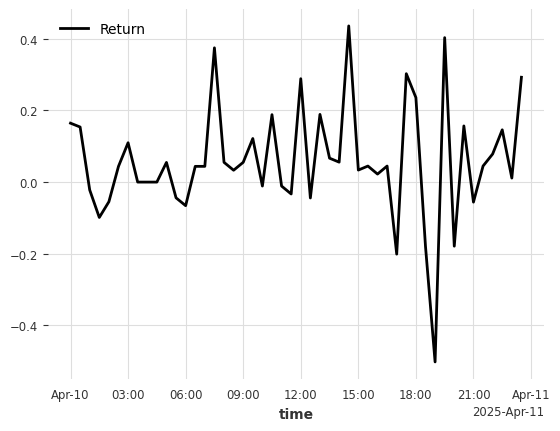

In [30]:
one_day_df = df.loc['2025-04-10']
one_day_df
series_one_day = TimeSeries.from_dataframe(one_day_df, value_cols='Return', freq='30min')
series_one_day.plot()

In [31]:
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

In [34]:
time_index = pd.date_range(start = series.start_time(),
                  freq = series.freq_str,
                  periods = df.shape[0])

month_series = datetime_attribute_timeseries(
                  time_index,
                  attribute = "month",
                  one_hot = True)

weekday_series = datetime_attribute_timeseries(time_index,
                                           attribute = "weekday",
                                            one_hot = True)

#cyclical covariates for hour
hour = time_index.hour
hour_sin = np.sin(2 * np.pi * hour / 24)
hour_cos = np.cos(2 * np.pi * hour / 24)

hour_df = pd.DataFrame({'hour_sin': hour_sin, 'hour_cos': hour_cos}, index=time_index)
hour_series = TimeSeries.from_dataframe(hour_df)

#cyclical covariates for half an hour
minute = time_index.minute
half_hour_fraction = minute / 60
half_hour_sin = np.sin(2 * np.pi * half_hour_fraction)
half_hour_cos = np.cos(2 * np.pi * half_hour_fraction)
half_hour_df = pd.DataFrame({'half_hour_sin': half_hour_sin, 'half_hour_cos': half_hour_cos}, index=time_index)
half_hour_series = TimeSeries.from_dataframe(half_hour_df)

covariates = month_series.stack(weekday_series).stack(hour_series).stack(half_hour_series)

In [35]:
covariates

<TimeSeries (DataArray) (time: 1439, component: 23, sample: 1)> Size: 265kB
array([[[ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 1.00000000e+00],
        ...,
        [ 9.65925826e-01],
        [ 1.22464680e-16],
        [-1.00000000e+00]],

       [[ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        ...,
        [ 1.00000000e+00],
        [ 0.00000000e+00],
        [ 1.00000000e+00]],

       [[ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        ...,
...
        ...,
        [ 7.07106781e-01],
        [ 1.22464680e-16],
        [-1.00000000e+00]],

       [[ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        ...,
        [ 8.66025404e-01],
        [ 0.00000000e+00],
        [ 1.00000000e+00]],

       [[ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        ...,
        [ 8.66025404e-01],
        [ 1.22464680e-16],
        [-1.00000000e+00]]])
Coordinates:
  * time       (time) datetime64[ns] 12kB 2025-03-31T23:30:00 ... 2025-04-30T...
  * component  (component) object 184B 'month_0' 'month_1' ... 'half_hour_cos'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [36]:
covariates_size = int(0.8 * len(covariates))
cov_train, cov_val = covariates[:covariates_size], covariates[covariates_size:]

In [37]:
model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0.1,
    n_rnn_layers =1,
    batch_size=16,
    n_epochs=50,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Forex_LSTM",
    log_tensorboard=True,
    random_state=42,
    training_length=40,
    input_chunk_length=35,
    force_reset=True,
    save_checkpoints=True,
    # pl_trainer_kwargs = {"accelerator": "gpu",
    #                                  "devices": [0]}
)

In [38]:
model.fit(
    train_transformed,
    future_covariates=covariates,
    val_series=val_transformed,
    val_future_covariates=covariates,
    verbose=True,
)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.7 K  | train
6 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0.1, training_length=40, batch_size=16, n_epochs=50, optimizer_kwargs={'lr': 0.001}, model_name=Forex_LSTM, log_tensorboard=True, random_state=42, input_chunk_length=35, force_reset=True, save_checkpoints=True)

In [39]:
pred_series = model.predict(n=50, future_covariates=covariates)
pred_series

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<TimeSeries (DataArray) (time: 50, component: 1, sample: 1)> Size: 400B
array([[[0.52851813]],

       [[0.60721659]],

       [[0.58266255]],

       [[0.64308666]],

       [[0.57193941]],

       [[0.56838901]],

       [[0.56170826]],

       [[0.53960962]],

       [[0.55007501]],

       [[0.52958911]],

...

       [[0.57646146]],

       [[0.5696664 ]],

       [[0.58092294]],

       [[0.57234038]],

       [[0.56920924]],

       [[0.55362894]],

       [[0.53516387]],

       [[0.52532177]],

       [[0.49940846]],

       [[0.5335475 ]]])
Coordinates:
  * time       (time) datetime64[ns] 400B 2025-04-24T23:00:00 ... 2025-04-25T...
  * component  (component) object 8B 'Return'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

<Axes: xlabel='time'>

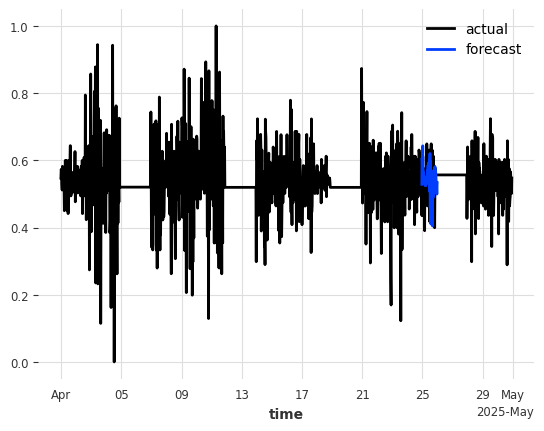

In [44]:
series_transformed.plot(label="actual")
pred_series.plot(label="forecast")

<Axes: xlabel='time'>

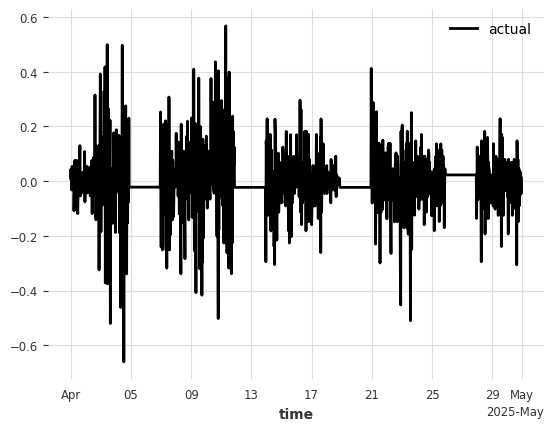

In [40]:

series.plot(label="actual")

<Axes: xlabel='time'>

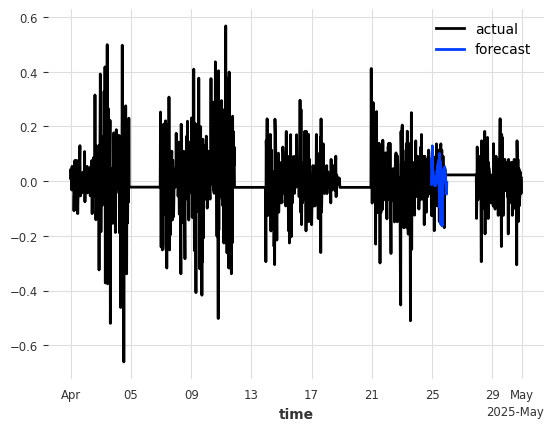

In [41]:
transformer = Scaler()
series_transformedd = transformer.fit_transform(series)
predictions = transformer.inverse_transform(pred_series)
series.plot(label='actual')
predictions.plot(label='forecast')

<Axes: xlabel='time'>

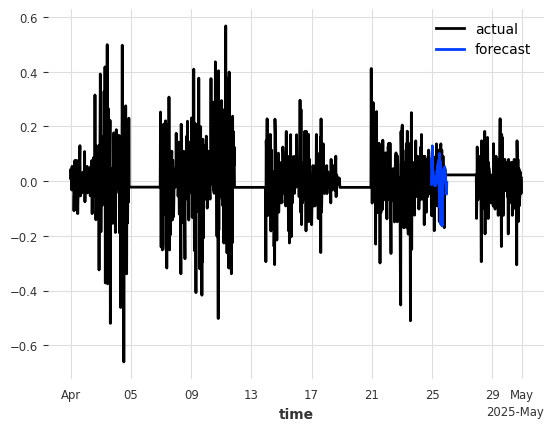

In [42]:
series.plot(label='actual')
predictions.plot(label='forecast')


<Axes: xlabel='time'>

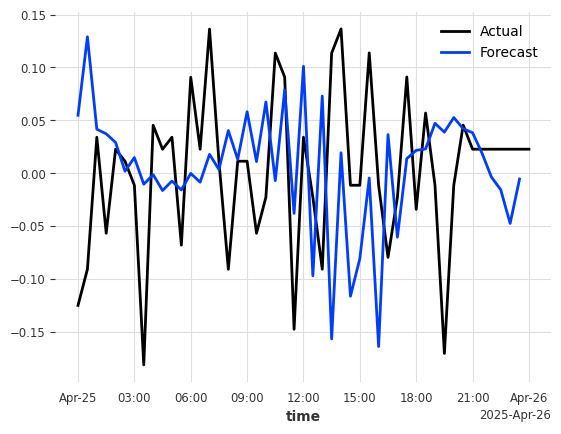

In [43]:
start_day = pd.Timestamp('2025-04-25')
end_day = pd.Timestamp('2025-04-26')
series_day = series.slice(start_day, end_day)
predictions_day = predictions.slice(start_day, end_day)
series_day.plot(label='Actual')
predictions_day.plot(label='Forecast')

# Parameter tuning


In [ ]:
param_grid = {'n_rnn_layers': [1, 2],
               'hidden_dim': [20],
               'dropout': [0.1],
                'n_epochs': [50, 80, 100],
                'lr':[0.003, 0.01],
                'input_chunk_length': [30, 35, 40, 45, 50],
                'output_chunk_length': [1, 3, 5, 10]}

grid = ParameterGrid(param_grid)
len(list(grid))

In [ ]:
val_size = int(0.2 * len(series))
val_size

In [ ]:
rmse = []
for params in grid:
  model = RNNModel(
    model="LSTM",
    hidden_dim=params['hidden_dim'],
    n_rnn_layers=params['n_rnn_layers'],
    dropout=params['dropout'],
    batch_size=16,
    n_epochs=params['n_epochs'],
    optimizer_kwargs={"lr": params['lr']},
    model_name="Forex_LSTM",
    log_tensorboard=True,
    random_state=42,
    training_length= params['input_chunk_length'] + params['output_chunk_length'],
    input_chunk_length=params['input_chunk_length'],
    force_reset=True,
    save_checkpoints=True,
    # pl_trainer_kwargs = {"accelerator": "gpu",
    #                                 "devices": [0]}
    )

  model.fit(
    train_transformed,
    future_covariates=covariates,
    val_series=val_transformed,
    val_future_covariates=covariates,
    verbose=True,
  )

  pred_series = model.predict(val_size, future_covariates=covariates)

  transformer = Scaler()
  series_transformed = transformer.fit_transform(series)
  predictions = transformer.inverse_transform(pred_series)

  start_date = predictions.start_time()
  end_date = predictions.end_time()
  series_actual = series.slice(start_date, end_date)

  actual_values = series_actual.values().flatten() # Use .values().flatten() to get a 1D numpy array
  predicted_values = predictions.values().flatten()

  error = np.sqrt(mean_squared_error(actual_values, predicted_values))
  rmse.append(error)

tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
tuning_results


# LSTM on seasonal and residual data

In [ ]:
import statsmodels.api as sm

res = sm.tsa.seasonal_decompose(df.Return, model="additive")
df1 = res.seasonal
df2 = res.resid
df1 = df1.to_frame()
df2 = df2.to_frame()
df1 = df1.fillna(0)
df2 = df2.fillna(0)
df1 = df1.rename(columns={'seasonal':'Return'})
df2 = df2.rename(columns={'resid':'Return'})
df = df1 + df2
df.head()

In [ ]:
series = TimeSeries.from_dataframe(df, value_cols='Return')
train_size = int(0.8 * len(series))
train, val = series[:train_size], series[train_size:]

In [ ]:
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

In [ ]:
year_series = datetime_attribute_timeseries(
    pd.date_range(start = series.start_time(),
                  freq = series.freq_str,
                  periods = df.shape[0]),
                  attribute = "year",
                  one_hot = False)

year_series = Scaler().fit_transform(year_series)

month_series = datetime_attribute_timeseries(year_series,
                                             attribute = "month",
                                             one_hot = True)

weekday_series = datetime_attribute_timeseries(year_series,
                                           attribute = "weekday",
                                            one_hot = True)


covariates_temp = year_series.stack(month_series)
covariates = covariates_temp.stack(weekday_series)

In [ ]:
covariates_size = int(0.8 * len(covariates))
cov_train, cov_val = covariates[:covariates_size], covariates[covariates_size:]

In [ ]:
model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0.1,
    n_rnn_layers =1,
    batch_size=16,
    n_epochs=50,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Forex_LSTM",
    log_tensorboard=True,
    random_state=42,
    training_length=40,
    input_chunk_length=35,
    force_reset=True,
    save_checkpoints=True,
    # pl_trainer_kwargs = {"accelerator": "gpu",
    #                                  "devices": [0]}
)

In [ ]:
model.fit(
    train_transformed,
    future_covariates=covariates,
    val_series=val_transformed,
    val_future_covariates=covariates,
    verbose=True,
)

In [ ]:
pred_series = model.predict(n=200, future_covariates=covariates)
pred_series
series_transformed.plot(label="actual")
pred_series.plot(label="forecast")

predictions = TimeSeries.pd_dataframe(pred_series)
start = predictions.index.min()
end = predictions.index.max()
actuals = df.Return[start:end]
forecasts = pred_series.pd_series()

error = np.sqrt(mean_squared_error(actuals, pred_series.values()))
error

# ARIMA on trend data


In [ ]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima, ARIMA, model_selection

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Magisterka2025/LSTM/data/EURUSD=X.csv")
df = df.drop([0,1])
df = df.rename(columns={'Price':'Date'})
headers = ['Close','High','Low','Open']
for header in headers:
  df[header]=df[header].astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date", inplace= True)


df['prev_close'] = df['Close'].shift(1)
df['Return']=(df['Close']/df['prev_close'] - 1)*100
df = df.iloc[1:]
df = df.loc[:, [ 'Return', 'Close', 'High', 'Low', 'Open', 'Volume', 'prev_close']]
df.head()

In [ ]:
res = sm.tsa.seasonal_decompose(df.Return, model="additive")
df = res.trend
df = df.to_frame()
df = df.fillna(0)
df = df.rename(columns={'trend':'Return'})
df.info()

In [ ]:
df = pd.DataFrame(df, columns=['Return'])
train, test = train_test_split(df, test_size=0.2, shuffle=False)

In [ ]:
auto_model = auto_arima(train['Return'], seasonal=False, trace=True)
auto_model.summary()


In [ ]:

arima_model = sm.tsa.arima.ARIMA(train, order=(4, 0, 2))
arima_fitted = arima_model.fit()

arima_forecast = arima_fitted.forecast(steps=len(test))

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Return'], label='Train')
plt.plot(test.index, test['Return'], label='Test')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--')
plt.title('ARIMA Forecast for Forex Prices')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()



In [ ]:
from sklearn.metrics import mean_squared_error
import math

In [ ]:
arima_rmse = math.sqrt(mean_squared_error(test['Return'], arima_forecast))
print(f"ARIMA RMSE: {arima_rmse:.4f}")

# ARIMA and LSTM together

In [ ]:
forecasts.head()

In [ ]:
full_forecast = arima_forecast + forecasts


In [ ]:
full_forecast.head()

In [ ]:
series_transformed.plot(label="actual")
full_forecast.plot(label="forecast")